# 1. Regresión Lineal Multiple

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from plot_post import plot_post

Muchas veces al estudiar un problema contamos con más de una variable predictora que pensamos puede ser de utilidad. Si nuestro objetivo fuese por ejemplo predecir el precio de una casa sería util tener en cuenta, los metros cuadrados construidos, la cantidad de habitaciones, la cantidad de baños, la ubicación de la casa (usando una variable categórica que indique por ejemplo el barrio), la disponibilidad de servicios, etc. En esos caso podemos extender la regresión lineal simple a lo que se conoce como regresión lineal múltiple, en ese caso tendremos:

$$\mu = \alpha + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 ... + \beta_n x_n$$

Ojo que esto no es lo mismo que en el caso de la regresión polinomial, ahora lo que tenemos son distintas variables $x_i$ indentificada cada una con un subíndice y no la misma variable $x$ elevada a sucesivas potencias (aunque nada nos impide tener una regresión polinomial múltiple!). La diferencia entre la regresión lineal simple y la múltiple es que en vez de usar una linea recta para explicar los datos ahora usamos un hiperplano de dimension $n$. De forma abrevida podríamos escribir:

$$\mu = \alpha + \sum_{i=1}\beta_i x_i$$

O incluso más breve, usando notacion matricial:

$$\mu = \alpha + \beta X$$

El modelo será basicamente el que ya vimos en la regresión lineal simple, con la única diferencia que ahora $\beta$ es un vector de coeficientes y $X$ una matriz de datos (con tantas columnas como variables predictoras y tantas filas como datos)

$$ Y \sim \mathcal{N}(\mu=\alpha + \beta X, \sigma=\epsilon) $$

Es decir los datos $Y$ son generados como una distribución Gaussiana con media $\alpha + \beta X$ y desviación estandard $\epsilon$.

Dado que desconocemos los valores de $\alpha$, $\beta$ y $\epsilon$ debemos fijar _a prioris_, una posibilidad serían los siguientes.

$$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) $$
$$\epsilon \sim U(0, h_{\epsilon}) $$

In [18]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_media = X.mean(axis=1, keepdims=True)
X_centrada = X - X_media
y = alfa_real + np.dot(beta_real, X) + eps_real

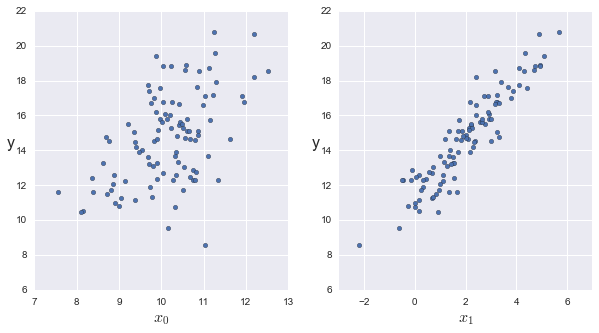

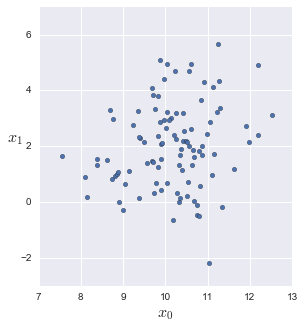

In [19]:
def scatter_plot(X, y):
    plt.figure(figsize=(10,5))
    for idx, x_i in enumerate(X):
        plt.subplot(1, len(X),idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('y', rotation=0, fontsize=16)

    plt.figure(figsize=(10,5))
    for idx in range(1, len(X)):
        plt.subplot(1, len(X),idx+1)
        plt.scatter(X[idx-1], X[idx])
        plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
        plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X, y)

Como es de esperar el modelo para la regresión lineal múltilple es muy similar al de la regresión lineal simple. Una aclaración importante es que en las lineas 6 y 8 se puede ver que hemos usando el producto punto para describir el modelo de forma abreviada. Es importante notar que no usamos la función _np.dot()_ si no que hemos escrito _pm.dot()_ Es decir estamos usando el producto punto implementado en PyMC3 (que en realidad no es más que un alias para una función de Theano), la razón es que el coeficiente $\beta$ en el modelo (linea 3) es un tensor de Theano y no un arreglo de NumPy.

In [20]:
with pm.Model() as modelo:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)

    mu = alpha_tmp + pm.dot(beta, X_centrada)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.dot(beta, X_media)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(5000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 3.6 sec

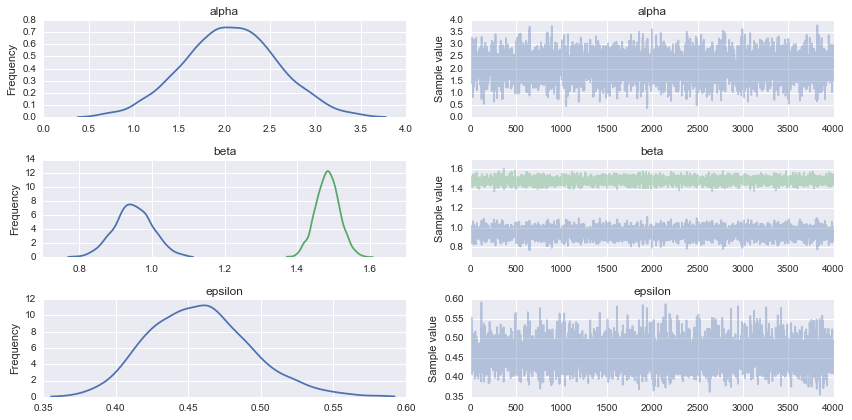

In [21]:
cadena = trace[1000::]
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(cadena, varnames);

In [22]:
pm.df_summary(cadena, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.070059,0.526294,0.007208,1.039592,3.084415
beta__0,0.948498,0.052449,0.000723,0.845905,1.052531
beta__1,1.483786,0.032647,0.000465,1.417995,1.547460
epsilon,0.457766,0.035087,0.000487,0.392771,0.528248


Como vemos nuestro modelo es capaz de recuperar los valores _reales_ que fijamos, aunque el valor para $\alpha$ tiene una incertidumbre grande, debido a que el valor de $x_1 = 0$ está fuera del rango (y muy alejado) de los valores de $x_1$.

Los modelos lineales múltiples son de mucha utilidad en estadística pero hay que ser cuidadosos al interpretarlos. En una regresión lineal múltiple el valor de cada coeficiente solo tiene sentido en el contexto de los valores de los demás parámetros. Por ejemplo el valor de $\alpha$ en el problema anterior es distinto si modelamos cada coeficiente $\beta$ por separado que si modelamos ambos juntos. En general lo que suele importar en una regresión suelen ser los valores de $\beta$, en las siguientes secciones veremos algunos cuidados que hay que tener al interpretar estos coeficientes.

## 1.1 Variables redundantes y variables de confusión

Un escenario común en un modelo con muchas variables es que dos (o más) variables estén correlacionadas entre si, es decir que aporten (al menos parcialmente) la misma información. En ese caso es posible que baste con incluir solo una de las variables, ya que la otra es redundante. Una situación en la que puede suceder esto es cuando una variable $z$ está correlacionada con una variable predictora $x$ y al mismo tiempo con la variable predicha $y$. A esa varible $z$ se le suele llamar variable de confusión o factor de confusión, la razón del nombre es la siguiente. Supongamos que desconocemos (o no hemos medido, o no hemos incluido en nuestro modelo) a la variable $z$ y decidimos hacer una regresión lineal entre $x$ e $y$, dado que $z$ tiene relación causal con $x$ y también con $y$, será posible usar $x$ para predecir $y$ aún cuando no exista una relación causal entre $x$ e $y$. Un ejemplo que vimos al iniciar el curso fue la relación inversa entre cantidad de piratas y el aumento de la temperatura global. El no considerar las variables de confusión (que en el caso de los piratas podría ser la revolución idustrial) en un análisis conduce a la aparición de variables o correlaciones [espurias](http://www.tylervigen.com/spurious-correlations). 

Una vez más que exista correlación y no implica que exista relación causal. En general la estadística solo sirve para determinar correlaciones, salvo que se cuente con un diseño experimental o en general con información que no está incluida en los modelos estadísticos. Un caso importante de variable de confusión se llama [paradoja de Simpson](https://es.wikipedia.org/wiki/Paradoja_de_Simpson), y se da cuando una asociación que parece tener un sentido (por ejemplo una correlación negativa) se invierte si consideramos la variable de confusión. El no incluir una variable de confusión podría no ser un problema si nuestro objetivo fuese solamente predecir una cantidad, pero si resulta problemático si se intenta comprender el mecanismo por el cual se relacionan las variables. Ya que en ese caso podríamos llegar a la conclusión de que los piratas tienen algún tipo de relación con el cambio climático! Por ello el criticar los modelos y las conclusiones derivadas de ellos, aún (quizá sobre todo) cuando el modelo parezca ser muy preciso es uno de los roles más importantes como científicos, lamentablemente no siempre los resultados sonarán tan sospechosos como con los piratas. 

A continuación generamos datos sintéticos de forma tal que la variable $x_1$ (variable de confusión) influya sobre $x_2$ y sobre $y$.

In [23]:
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)  # cambiar según se indica más adelante.  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

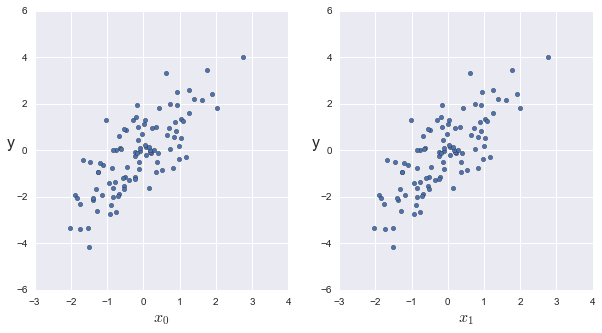

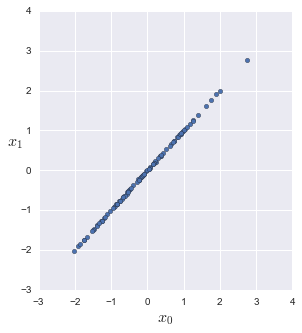

In [24]:
scatter_plot(X, y)

In [26]:
X_media = X.mean(axis=1, keepdims=True)
X_centrada = X - X_media
# scatter_plot(X, y)

In [27]:
with pm.Model() as modelo:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)

    mu = alpha_tmp + pm.dot(beta, X_centrada)
    #mu = alpha_tmp + pm.dot(beta, X_centrada[0])

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.dot(beta, X_media))
    #alpha = pm.Deterministic('alpha', alpha_tmp - pm.dot(beta, X_media[0]))
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(5000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 21.8 sec

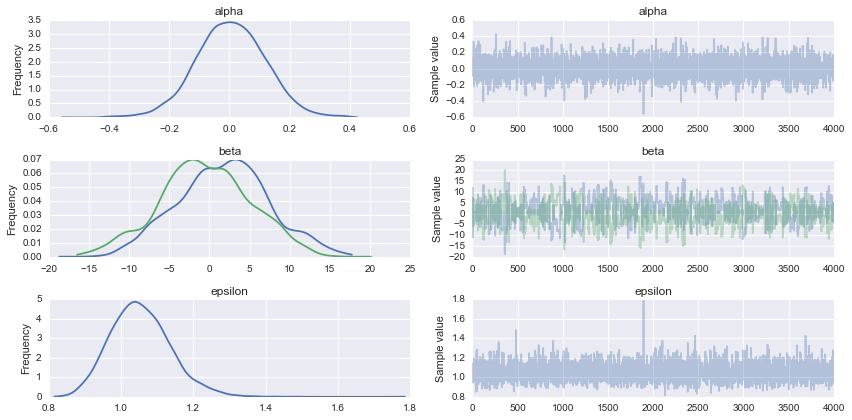

In [28]:
cadena = trace[1000::]
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(cadena, varnames);

In [29]:
pm.df_summary(cadena, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,0.005055,0.114807,0.002000,-0.226867,0.220422
beta__0,1.764323,5.746700,0.322455,-9.244164,13.139019
beta__1,-0.491611,5.746979,0.322274,-11.980900,10.429646
epsilon,1.054127,0.083293,0.001311,0.907392,1.229627


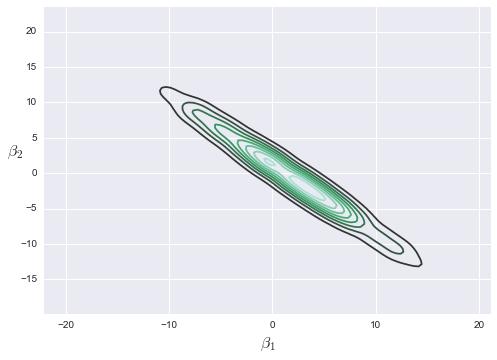

In [30]:
sns.kdeplot(cadena['beta'][:,0], cadena['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0);

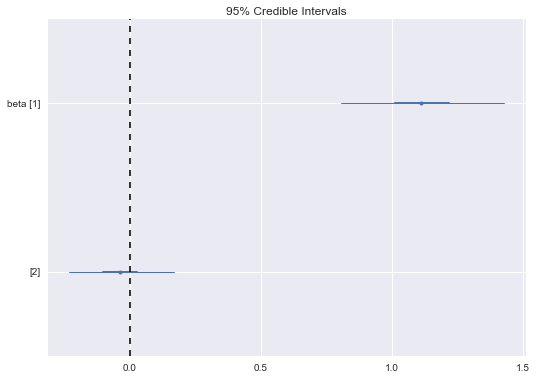

In [15]:
pm.forestplot(cadena, varnames=['beta']);

Como se puede ver según el _a posteriori_ el coeficiente $\beta$ para la variable $x_2$ es cercano a cero, indicando que su controbución a explicar $y$ es minima en presencia de $x_1$. ¿Cuáles son los coeficientes $\beta$ si hacemos una regresión lineal simple para $x_1$ y otra para $x_2$?

Como se puede ver el coeficiente $\beta$ para $x_2$ es más bajo en la regresión lineal múltiple que en la regresión lineal simple. La capacidad de $x_2$ de explicar $y$ se hace prácticamente nula al incluir $x_1$. En este caso el modelo nos ha servido para eliminar una variable espuria. Esto no es magia es simplemente el resultado de haber incluido la variable de confusión.

## 1.2 Multicolinearidad (o cuando la correlación es demasiado alta)

En el caso anterior las variables predictoras estaban correlacionadas siendo una de ellas redundante. Veamos ahora que sucede si aumentamos la correlación de las variables por ejemplo si generamos los datos sintéticos usando _scale = 0.01_ (pueden luego probar con valores menos extremos)

Como se puede ver en este caso extremo las dos variables tiene una correlación tan alta (de hecho ambas variables son prácticamente idénticas) el _a posteriori_ para $\beta$ es muy angosto. A que se debe esto? Según el modelo la media $\mu$ es:

$$\mu = \alpha + \beta_1 x_1 + \beta_1 x_2 $$

Pero dado que $x_1$ y $x_2$ son prácticamente idénticos podemos reescribir el modelo de la siguiente forma:

$$\mu = \alpha + (\beta_1 + \beta_2) x $$

Entonces resulta que es la suma de $\beta_1 + \beta_2$ (y no sus valores por separado) lo que influencia la media $\mu$, existe entonces una cantidad infinita de combinaciones de los coeficientes $\beta$ que satisfacen al modelo y eso es precisamente lo que muestra el _a posteriori_, la única razón por la cual el _a posteriori_ marginal de $\beta$ no _explota_ y muestra valores de [$-\infty, \infty$] es por que hay un _a priori_ que restringe los valores posibles de $\beta$.

¿Quiere decir esto que el análisis está mal o que el _a posteriori_ es incorrecto? No, el _a posteriori_ simplemente refleja el hecho que es posible explicar los datos usando una combinación _infinita_ de coeficientes, la cual solo está restringida por los _a prioris_. El modelo es bueno haciendo predicciones solo que resulta dificil interpretar los parámetros.

Cuan fuerte tiene que ser la correlación para que empieze a ser preocupante. No existe una respuesta única a la pregunta. Una posibilidad es calcular la matriz de correlación para todas las variables previo a gener el modelo, correlaciones por encima de 0.9 pueden ser preocupantes. Sin embargo hay que tener cuidado ya que lo que realmente importa no son las correlaciones de a pares si no la correlación una vez aramado el modelo. Además podría darse el caso que una variable es redundante respecto de otra pero al incluir una tercer variable en el modelo esta variable ayude a _extraer_ parte de la porción no redundante de información. Como ya dijimos las regresiones lineales multiples pueden ser complicadas de interpretar. Una forma de diagnosticar este problema se da al ver como el HDI (o la desviación estádar) de los parámetros en el _a posteriori_ _explota_ cuando las variables corelacionas forman parte del modelo. La autocorrelación durante el muestreo tambińe puede ser usado para diagnosticar el problema, como es de esperar usando NUTS la autocorrelación es más baja que usando Metropolis.

Que se puede hacer en caso de encontrarse con variables predictoras redundantes? 

* Si las correlación es perfecta (o en general _muy alta_) es posible eliminar una de las variables, ya que las variables tienen la misma (o aproximadamente la misma información) entonces será posible eliminar una de ellas por pura conveniencia , por ej podemos eliminar la que sea más dificil de medir, la variable menos usada/conocida en nuestra disciplina, la que puede ser confuso interpretar, etc.

* Otra posibilidad es crear una nueva variable tomando el promedio de las variables correlacionadas (aunque esto puede complicar la interpretación del modelo). Una versión más sofisticada es usar un algoritmo de reduccion de dimensionalidad como el Análisis de las Componentes Principales (PCA en inglés). El problema es que las variables que devuelve un PCA son combinaciones lineales de las variables originales, lo cual en la gran mayoría de los casos es terriblemente confuso o incluso imposible de interpretar.

En el caso anterior las variables predictoras estaban correlacionadas siendo una de ellas redundante. Veamos ahora que sucede si aumentamos la correlación de las variables por ejemplo si generamos los datos sintéticos usando _scale = 0.01_ (pueden luego probar con valores menos extremos)

Como se puede ver en este caso extremo las dos variables tiene una correlación tan alta (de hecho ambas variables son prácticamente idénticas) el _a posteriori_ para $\beta$ es muy angosto. A que se debe esto? Según el modelo la media $\mu$ es:

$$\mu = \alpha + \beta_1 x_1 + \beta_1 x_2 $$

Pero dado que $x_1$ y $x_2$ son prácticamente idénticos podemos reescribir el modelo de la siguiente forma:

$$\mu = \alpha + (\beta_1 + \beta_2) x $$

Entonces resulta que es la suma de $\beta_1 + \beta_2$ (y no sus valores por separado) lo que influencia la media $\mu$, existe entonces una cantidad infinita de combinaciones de los coeficientes $\beta$ que satisfacen al modelo y eso es precisamente lo que muestra el _a posteriori_, la única razón por la cual el _a posteriori_ marginal de $\beta$ no _explota_ y muestra valores de [$-\infty, \infty$] es por que hay un _a priori_ que restringe los valores posibles de $\beta$.

¿Quiere decir esto que el análisis está mal o que el _a posteriori_ es incorrecto? No, el _a posteriori_ es simplemente una consecuencia lógica del modelo y los datos, es posible explicar los datos usando una combinación _infinita_ de coeficientes, la cual solo está restringida por los _a prioris_. Además, el modelo es bueno haciendo predicciones solo que resulta dificil interpretar los parámetros.

¿Cuán fuerte tiene que ser la correlación para que empieze a ser preocupante? No existe una respuesta única a la pregunta. Una posibilidad es calcular la matriz de correlación para todas las variables previo a gener el modelo, correlaciones por encima de 0.9 pueden ser preocupantes. Sin embargo hay que tener cuidado ya que lo que realmente importa no son las correlaciones de a pares si no la correlación una vez armado el modelo. Además podría darse el caso que una variable es redundante respecto de otra pero al incluir una tercer variable en el modelo esta variable ayude a _extraer_ parte de la porción no redundante de información. Como ya dijimos las regresiones lineales multiples pueden ser complicadas de interpretar. Una forma de diagnosticar este problema se da al ver como el HDI (o la desviación estádar) de los parámetros en el _a posteriori_ _explota_ cuando las variables corelacionas forman parte del modelo. La autocorrelación durante el muestreo tambińe puede ser usado para diagnosticar el problema, como es de esperar usando NUTS la autocorrelación es más baja que usando Metropolis.

¿Qué se puede hacer en caso de encontrarse con variables predictoras redundantes? 

* Si las correlación es perfecta (o en general _muy alta_) es posible eliminar una de las variables, ya que las variables tienen la misma (o aproximadamente la misma información) entonces será posible eliminar una de ellas por pura conveniencia , por ej podemos eliminar la que sea más dificil de medir, la variable menos usada/conocida en nuestra disciplina, la que puede ser confuso interpretar, etc.

* Otra posibilidad es crear una nueva variable tomando el promedio de las variables correlacionadas (aunque esto puede complicar la interpretación del modelo). Una versión más sofisticada es usar un algoritmo de reduccion de dimensionalidad como el Análisis de las Componentes Principales (PCA en inglés). El problema es que las variables que devuelve un PCA son combinaciones lineales de las variables originales, lo cual en la gran mayoría de los casos es terriblemente confuso o incluso imposible de interpretar.

## 1.3 Variables que enmascaran efectos

Veamos ahora el caso en que hay variables que enmascaran efectos. Esto se da por ejemplo cuando una de las variable predictoras está correlacionada positivamente y la otra negativamente con la variable predicha.

In [34]:
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0*r, scale=np.sqrt(1-r**2))
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

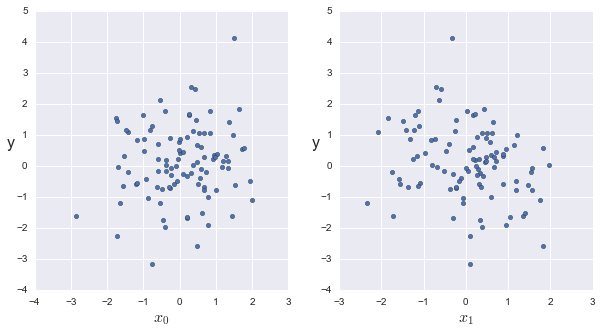

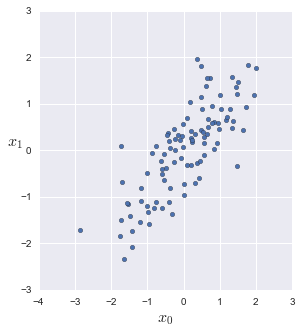

In [35]:
scatter_plot(X, y)

In [36]:
X_media = X.mean(axis=1, keepdims=True)
X_centrada = X - X_media
# scatter_plot(X, y)

In [37]:
with pm.Model() as modelo:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)

    mu = alpha_tmp + pm.dot(beta, X_centrada)
    #mu = alpha_tmp + pm.dot(beta, X_centrada[0])

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.dot(beta, X_media)) 
    #alpha = pm.Deterministic('alpha', alpha_tmp - pm.dot(beta, X_media[0])) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(5000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 4.1 sec

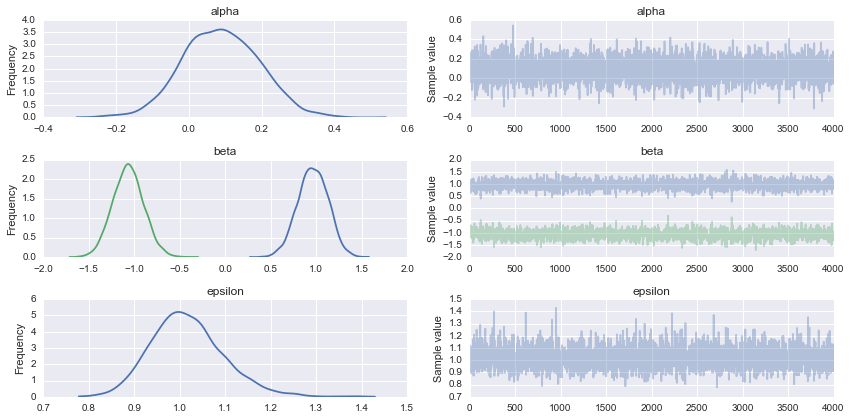

In [38]:
cadena = trace[1000::]
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(cadena, varnames);

In [39]:
pm.df_summary(cadena, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,0.089123,0.104856,0.001278,-0.103277,0.295385
beta__0,0.964081,0.165630,0.003983,0.660044,1.297112
beta__1,-1.065410,0.169831,0.004279,-1.412149,-0.750010
epsilon,1.017025,0.080339,0.001284,0.868680,1.178262


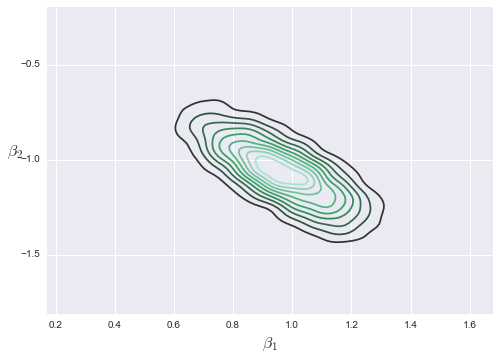

In [40]:
sns.kdeplot(cadena['beta'][:,0], cadena['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0);

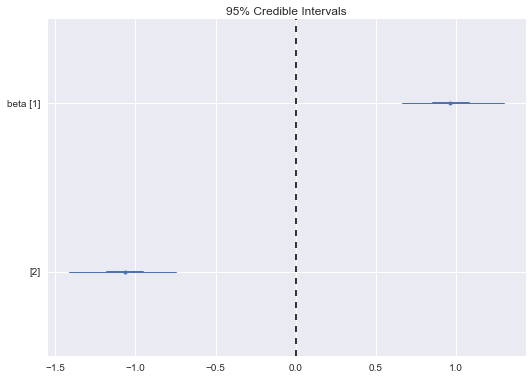

In [41]:
pm.forestplot(cadena, varnames=['beta']);

Según nuestro análisis los valores de $\beta$ son cercanos a 1 y -1, es decir $x_1$ está correlacionado positivamente con $y$ mientras que $x_2$ lo está negativamente. Pero ¿Qué pasa si repetimos el análisis anterior para solo una de las variables?

En ese caso veremos que para cualquiera de las dos variables que usemos los coeficientes $\beta$ estarán ahora mucho más próximos a 0. Qué es lo que acaba de pasar acá?

Cuando $x_1$ aumenta tambien lo hace $x_2$ y cuando $x_2$ aumenta $y$ disminuye, por lo tanto si miramos la relacion de $x_1$ sobre $y$ sin tener en cuenta que está pasando con $x_2$, nos dará la impresión de que al aumentar $x_1$ la variable $y$ solo aumenta de forma modesta (y que al aumentar $x_2$ la variable $y$ disminuye solo modestamente). Sin embargo, al combinar $x_1$ con $x_2$ veremos que el efecto de cada una de estas variables sobre $y$ es realmenten notorio.

### 1.3.1 Interacciones

Los modelos anteriores consideran que un cambio en $x_i$ genera un cambio constante en $y$ (para valores fijos de los demás predictores), pero prodría pasar que el cambio que produce $x_i$ está modulado por cambios en $x_j$. Un caso clásico es la interacción que se produce entre dos drogas, por ejemplo aumentar la dosis de una droga $A$ resulta en un efecto positivo cuando la dosis de una segunda droga $B$ es nula o pequeña, pero el efecto de $A$ se hace negativo a medida que se aumenta $B$. Matemáticamente esto se traduce en que los valores predichos no necesariamente son una combinación aditiva de las variables predictoras. Existen diferentes formas funcionales que dan cuenta de las interacciones entre variables una forma muy común es la multiplicación. En ese caso una regresión lineal múltiple que tiene en cuenta interacciones se vería como:

$$\mu = \alpha + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1x_2$$

En una regresión lineal multiple el espacio posible de soluciones es una (hiper)superficie plana. El usar términos multiplicativos resulta en una (hiper)superficie curva.

## 1.4 Para seguir leyendo

* Más sobre modelos generalizados lineales en:
    * Capítulo 18 de [Doing Bayesian Data Analysis (2 edición)](www.amazon.com/gp/product/0124058884) de John Kruschke.
    * Capítulo 5 de [Statistical Rethinking](https://www.crcpress.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-Stan/McElreath/9781482253443) de Richard McElreath.
    * Capítulos 14 a 17 de [Bayesian Data Analysis](www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954) de Andrew Gelman
    

* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)   


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)

In [24]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo Ubuntu 15.10 y usando:
Python 3.5.0
IPython 4.1.1
PyMC3 3.0
NumPy 1.10.4
SciPy 0.17.0
Matplotlib 1.5.1
Seaborn 0.7.0

